In [12]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import json
import copy

In [2]:
# Load your usual SpaCy model (one of SpaCy English models)
import spacy
import re
nlp = spacy.load('en_core_web_lg')

# Add neural coref to SpaCy's pipeline
import neuralcoref
neuralcoref.add_to_pipe(nlp)

In [186]:
def clean_wikitext(text):
    cleaned = re.sub(r'\[.{1,2}\]', '', text)
    cleaned = re.sub(r'\(([^\)]*[^\)]*?)\)', '', cleaned)
    return cleaned

def print_clusters(items):
    for i in items:
        print(i)
    print()
        
def get_people_ents(span):
    return [e for e in span.ents if e.label_ == 'PERSON']

# gets a list tuples, where each tuple contains two list - l1 and l2
# where l1 represents all coreferred entities
# where l2 represents its coreferences (pronouns)
# can have multiple in l1 due to multiple people and "theys"
def get_cluster_pairs(spacy_doc):
    clusters = spacy_doc._.coref_clusters
    clusters = [c for c in clusters if len(get_people_ents(c.main)) > 0]
    paired_clusters = [(get_people_ents(c.main), c.mentions[1:]) for c in clusters]
    return paired_clusters

def flatten_cluster_pairs(pairs):
    return sum([p[0] + p[1] for p in pairs], []) # flatten arary of tupled mentions

def get_relevant_annotations(spacy_doc, flat_pairs):
    entities = get_people_ents(spacy_doc)
    
    for ent in flat_pairs:
        if ent not in entities:
            entities.append(ent)
            
    return entities

def create_label_annotations(text):
    global nlp
    spacy_doc = nlp(text)
    cluster_pairs = get_cluster_pairs(spacy_doc)
    flat = flatten_cluster_pairs(cluster_pairs)
    annotations = get_relevant_annotations(spacy_doc, flat)
    
    res = {'data': {'text': text}, 'predictions': [{'result': []}]}
    to_add = res['predictions'][0]['result']
    
    template = {
        'from_name': 'label',
        'to_name': 'txt-99',
        'type': 'labels',
    }
    
    for ent in annotations:
        template['value'] = {
            'start': ent.start_char,
            'end': ent.end_char,
            'text': ent.text,
            'labels': ['entity']
        }
        
        to_add.append(copy.deepcopy(template))
        
    return res
    
# clean_wikitext('Maria "Maja" Einstein (18 November 1881 – 25 June 1951) and her older brother, Albert, were the two children of Hermann Einstein and Pauline Einstein (née Koch), who had moved from Ulm to Munich in June 1881, when Albert was one.[14] There Hermann and his brother Jakob had founded Einstein & Cie., an electrical ')

In [454]:
class Entity:
    def __init__(self, text, ID, start=-1, end=-1):
        self.text = text
        self.ID = ID
        self.start = start
        self.end = end
        self.str_repr = f'{self.text} ({self.ID[:3]})'
        
    def __eq__(self, e2):
        return self.ID == e2.ID
    
    def __hash__(self):
        return hash((self.ID, self.text))
    
    def __str__(self):
        return self.str_repr
    
    def __repr__(self):
        return self.str_repr
    
# Relation labels are of the format:
# 'bidirectional', 'f', 'b'
# :
# 'parent-child', 'son-of', etc.
class Relation:
    def __init__(self, e1, e2, label):
        self.label = label.split(':')[1]
        self.label_type = label.split(':')[0]
        
        if self.label_type != 'b':
            self.e1 = e1
            self.e2 = e2
        else:
            self.e1 = e2
            self.e2 = e1
        
    def __str__(self):
        if self.label_type == 'bidirectional':
            return f'[{self.label}] {str(self.e1)} <---> {str(self.e2)}'
        else:
            return f'[{self.label}] {str(self.e1)} ---> {str(self.e2)}'
        
    def __repr__(self):
        if self.label_type == 'bidirectional':
            return f'[{self.label}] {str(self.e1)} <---> {str(self.e2)}'
        else:
            return f'[{self.label}] {str(self.e1)} ---> {str(self.e2)}'
        
    def get_span(self, text, edge_chars=0):
        if self.e1.start < self.e2.start:
            pre_chars = self.e1.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e1.start]
            post_chars = self.e2.end + edge_chars
            post_chars = text[self.e2.end:post_chars]
            return f'{pre_chars}{text[self.e1.start : self.e2.end]}{post_chars}'
        else:
            pre_chars = self.e2.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e2.start]
            post_chars = self.e1.end + edge_chars
            post_chars = text[self.e1.end:post_chars]
            return f'{pre_chars}{text[self.e2.start : self.e1.end]}{post_chars}'
        
    def get_annotated_span(self, text, e1_func, e2_func, edge_chars=0):
        e1_annotated = e1_func(text[self.e1.start : self.e1.end])
        e2_annotated = e2_func(text[self.e2.start : self.e2.end])
        if self.e1.start < self.e2.start:
            pre_chars = self.e1.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e1.start]
            post_chars = self.e2.end + edge_chars
            post_chars = text[self.e2.end:post_chars]
            return f'{pre_chars}{e1_annotated}{text[self.e1.end : self.e2.start]}{e2_annotated}{post_chars}'
        else:
            pre_chars = self.e2.start - edge_chars
            pre_chars = 0 if pre_chars < 0 else pre_chars
            pre_chars = text[pre_chars:self.e2.start]
            post_chars = self.e1.end + edge_chars
            post_chars = text[self.e1.end:post_chars]
            return f'{pre_chars}{e2_annotated}{text[self.e2.end : self.e1.start]}{e1_annotated}{post_chars}'
        

class DocRelations:
    def __init__(self, doc, with_negatives=False):
        self.text = doc['data']['text']
        self.doc_ID = doc['id']
        self.entities = {}
        self.entity_rels = {}
        self.num_entities = 0
        self.num_relations = 0
        
        for ent in doc['annotations'][0]['result']:
            if ent['type'] == 'labels':
                self.num_entities += 1
                val = ent['value']
                self.entities[ent['id']] = Entity(val['text'], ent['id'], val['start'], val['end'])
                
        for ann in doc['annotations'][0]['result']:
            if ann['type'] == 'relation':
                for lab in ann['labels']:
                    ent1 = self.entities[ann['from_id']]
                    ent2 = self.entities[ann['to_id']]
                    rel = Relation(ent1, ent2, lab)
                    
                    self.add_relationship(rel)
                        
        if with_negatives:
            for i in range(self.num_relations):
                self.add_relationship(self.new_negative_rel(inorder=True))
    
    # relation must be of class Relation
    def add_relationship(self, relation):
        self.num_relations += 1
        
        if relation.e1 not in self.entity_rels:
            self.entity_rels[relation.e1] = []
        self.entity_rels[relation.e1].append(relation)
        
                        
    def are_related(self, e1, e2):
        if e1 in self.entity_rels and e2 in [rel.e2 for rel in self.entity_rels[e1]]:
            return True
        if e2 in self.entity_rels and e1 in [rel.e2 for rel in self.entity_rels[e2]]:
            return True
        return False
                        
    def new_negative_rel(self, inorder=False):
        (e1, e2) = np.random.choice(list(self.entities.values()), size=(2,), replace=False)
        
        iter = 0
        while self.are_related(e1, e2):
            (e1, e2) = np.random.choice(list(self.entities.values()), size=(2,), replace=False)
            iter += 1
            if iter > 100:
                print('****\n\nHIGH PROBABILITY OF MAXIMUM RELATIONSHIPS\n\n****')
            
        # guarantees e1 is always before e2 in a span of text
        if inorder:
            if e2.start < e1.start:
                (e1, e2) = (e2, e1)
        
        return Relation(e1, e2, 'n:no-rel')
    
    def get_relationships(self):
        return [subl for top_list in self.entity_rels.values() for subl in top_list]
        
        

In [455]:
with open('docs_wiki.txt') as f:
    txt_content = f.read()

docs = txt_content.split('\n')
docs = [clean_wikitext(d.strip()) for d in docs if d != '']

data = []

for doc in docs:
    data.append(create_label_annotations(doc))

with open('data.json', 'w') as f:
    json.dump(data, f)

In [456]:
with open('exported.json', 'r') as f:
    data = json.load(f)
    
data[7]['id']

4

In [457]:
test = DocRelations(data[2], with_negatives=True)
test.entity_rels

{Arnold Alois Schwarzenegger (zfQ): [[parent-child] Arnold Alois Schwarzenegger (zfQ) <---> Gustav Schwarzenegger (jGl),
  [son-of] Arnold Alois Schwarzenegger (zfQ) ---> Gustav Schwarzenegger (jGl),
  [parent-child] Arnold Alois Schwarzenegger (zfQ) <---> Aurelia (go-),
  [son-of] Arnold Alois Schwarzenegger (zfQ) ---> Aurelia (go-),
  [no-rel] Arnold Alois Schwarzenegger (zfQ) ---> his (gpp),
  [no-rel] Arnold Alois Schwarzenegger (zfQ) ---> his (7SI),
  [no-rel] Arnold Alois Schwarzenegger (zfQ) ---> Schwarzenegger (5TK)],
 Gustav Schwarzenegger (jGl): [[father-of] Gustav Schwarzenegger (jGl) ---> Arnold Alois Schwarzenegger (zfQ),
  [marriage] Gustav Schwarzenegger (jGl) <---> Aurelia (go-),
  [husband-of] Gustav Schwarzenegger (jGl) ---> Aurelia (go-),
  [no-rel] Gustav Schwarzenegger (jGl) ---> Kunigunde Schwarzenegger (3ei),
  [no-rel] Gustav Schwarzenegger (jGl) ---> Schwarzenegger (5TK),
  [no-rel] Gustav Schwarzenegger (jGl) ---> his (7SI)],
 Aurelia (go-): [[mother-of] Aurel

In [508]:
def get_bert_data(doc, transform_e1, transform_e2, boundary_chars):
    bert_data = {
        'text': [],
        'relationship': [],
        'type': [],
        'doc_ID': []
    }
    
    for rel in doc.get_relationships():
        bert_data['text'].append(rel.get_annotated_span(doc.text, transform_e1, transform_e2, boundary_chars))
        bert_data['relationship'].append(rel.label)
        bert_data['type'].append(rel.label_type)
        bert_data['doc_ID'].append(doc.doc_ID)
    
    return bert_data

def make_dataset(doc_json, transform_e1, transform_e2, boundary_chars):
    with open('exported.json', 'r') as f:
        docs = json.load(f)

    text = []
    relationships = []
    types = []
    doc_IDs = []
    
    for exported_data in docs:
        doc = DocRelations(exported_data, with_negatives=True)
        doc_data = get_bert_data(doc, transform_e1, transform_e2, boundary_chars)
        text = text + doc_data['text']
        relationships = relationships + doc_data['relationship']
        types = types + doc_data['type']
        doc_IDs = doc_IDs + doc_data['doc_ID']
    
    return pd.DataFrame({
        'text' : text,
        'relationship' : relationships,
        'type' : types,
        'doc_ID': doc_IDs
    })

In [509]:
data = {
    'text': [1, 2, 3],
    'relationship': [4, 2, 1],
    'type': [4, 3, 1]
}

data_2 = {
    'text': [2, 4, 1],
    'relationship': [5, 3, 1],
    'type': [6, 3, 1]
}

z = {**data, **data_2}
z

{'text': [2, 4, 1], 'relationship': [5, 3, 1], 'type': [6, 3, 1]}

In [510]:
t_e1 = lambda e: f'[E1] {e} [/E1]'
t_e2 = lambda e: f'[E2] {e} [/E2]'
boundary_chars = 40
df = make_dataset('exported.json', t_e1, t_e2, boundary_chars)
df

,text,relationship,type,doc_ID
0,"[E1] Davis [/E1] met his wife-to-be, [E2] Shar...",marriage,bidirectional,10
1,"[E1] Davis [/E1] met his wife-to-be, [E2] Shar...",husband-of,f,10
2,"[E1] Davis [/E1] met his wife-to-be, Sharon Ry...",no-rel,n,10
3,"[E1] Davis [/E1] met his wife-to-be, Sharon Ry...",no-rel,n,10
4,"[E2] Davis [/E2] met his wife-to-be, [E1] Shar...",wife-of,b,10
...,...,...,...,...
217,"n June 1881, when Albert was one. There [E1] H...",no-rel,n,4
218,"n June 1881, when Albert was one. There [E2] H...",brother-of,b,4
219,when Albert was one. There Hermann and [E2] h...,brother-of,b,4
220,when Albert was one. There Hermann and [E1] h...,siblings,bidirectional,4


In [504]:
df.iloc[220]['text']

' when Albert was one. There Hermann and [E1] his [/E1] brother [E2] Jakob [/E2] had founded Einstein & Cie., an electri'

In [516]:
bidirectional = df[df['type'] == 'bidirectional']
no_rel = df[df['type'] == 'n']
no_rel = no_rel.sample(frac=len(bidirectional)/len(no_rel))
len(no_rel)

37

In [64]:
def get_entities(paragraph):
    global nlp, doc
    doc = nlp(paragraph)
    res = []
    people = [e for e in doc.ents if e.label_ == 'PERSON']
    for p in people:
        res.append({
            'text': p.text, #string
            'text_with_ws': p.text_with_ws,
            'trailing_ws': True if len(p.text_with_ws) > len(p.text) else False,
            'start': p.start_char, #int
            'end': p.end_char, #int
        })
        
    return res

get_entities(docs[0])[:3]

[{'text': 'Kimberly Noel Kardashian',
  'text_with_ws': 'Kimberly Noel Kardashian ',
  'trailing_ws': True,
  'start': 0,
  'end': 24},
 {'text': 'Robert',
  'text_with_ws': 'Robert ',
  'trailing_ws': True,
  'start': 86,
  'end': 92},
 {'text': 'Kris Kardashian',
  'text_with_ws': 'Kris Kardashian ',
  'trailing_ws': True,
  'start': 97,
  'end': 112}]

In [69]:
[e for e in nlp(docs[0]).ents if e.label_ == 'PERSON']

[Kimberly Noel Kardashian,
 Robert,
 Kris Kardashian,
 Kourtney,
 Rob,
 Bruce Jenner,
 Kim Kardashian,
 Burton "Burt",
 Brandon,
 Brody,
 Casey,
 Kendall,
 Kylie Jenner]

In [230]:
def print_clusters(items):
    for i in items:
        print(i)
    print()
        
def get_people_ents(span):
    return [e for e in span.ents if e.label_ == 'PERSON']

# gets a list tuples, where each tuple contains two list - l1 and l2
# where l1 represents all coreferred entities
# where l2 represents its coreferences (pronouns)
# can have multiple in l1 due to multiple people and "theys"
def get_cluster_pairs(doc):
    clusters = doc._.coref_clusters
    clusters = [c for c in clusters if len(get_people_ents(c.main)) > 0]
    paired_clusters = [(get_people_ents(c.main), c.mentions[1:]) for c in clusters]
    return

def flatten_cluster_pairs(pairs):
    return sum([pair[0] + pair[1] for pair in my_clusters], []) # flatten arary of tupled mentions

def get_relevant_annotations(doc, flat_pairs):
    entities = get_people_ents(doc)
    
    for ent in flat_pairs:
        if ent not in entities:
            entities.append(ent)
            
    return entities

[Kimberly Noel Kardashian,
 Robert,
 Kris Kardashian,
 Kourtney,
 Rob,
 Bruce Jenner,
 Kim Kardashian,
 Burton "Burt",
 Brandon,
 Brody,
 Casey,
 Kendall,
 Kylie Jenner,
 She,
 her,
 Their,
 their,
 their,
 their]

In [232]:
test_doc = nlp(docs[0])
cluster_pairs = get_cluster_pairs(test_doc)
flat = flatten_cluster_pairs(cluster_pairs)
annotations = get_relevant_annotations(test_doc, flat)
print(annotations)

[Kimberly Noel Kardashian, Robert, Kris Kardashian, Kourtney, Rob, Bruce Jenner, Kim Kardashian, Burton "Burt", Brandon, Brody, Casey, Kendall, Kylie Jenner, She, her, Their, their, their, their]


In [251]:
def create_label_annotations(text):
    global nlp
    doc = nlp(text)
    cluster_pairs = get_cluster_pairs(doc)
    flat = flatten_cluster_pairs(cluster_pairs)
    annotations = get_relevant_annotations(doc, flat)
    
    res = {'data': {'text': text}, 'predictions': [{'result': []}]}
    to_add = res['predictions'][0]['result']
    
    template = {
        'from_name': 'label',
        'to_name': 'txt-99',
        'type': 'labels',
    }
    
    for ent in annotations:
        template['value'] = {
            'start': ent.start_char,
            'end': ent.end_char,
            'text': ent.text,
            'labels': ['entity_1']
        }
        
        to_add.append(copy.deepcopy(template))
        
    return res

In [ ]:
data = []

for doc in docs:
    data.append(create_label_annotations(docs[0]))

with open('data.json', 'w') as f:
    json.dump(data, f)

In [90]:
test2 = nlp("West raised Kanye in the Chicago area along with her husband, Ray, from whom she separated when Kanye was 3. She retired in 2004 and moved to California to work full-time for her son. She was often seen at his side at parties and award shows. She was also a firm defender of her son\'s sometimes controversial comments. West said that she trained her son for greatness.")
test2._.coref_clusters


[West: [West, West],
 Kanye: [Kanye, Kanye],
 her: [her, she, She, her, She, She, her, she, her],
 her son: [her son, his, her son, her son]]

In [63]:
def get_relationships(paragraph):
    global nlp, doc
    res = []
    doc = nlp(paragraph)
    doc_len = len(doc.text)
    found_entities = [(e, doc[:0]) for e in doc.ents if e.label_ == 'PERSON']
    clusters = doc._.coref_clusters
    
    # Remove all clusters that don't have a named entity in the main resolved span
    clusters = [c for c in clusters if len(c.main.ents) > 0]

    # Remove all clusters that don't contain a PERSON named entity in the main resolved span
    clusters = [c for c in clusters if len([c_ent for c_ent in c.main.ents if c_ent.label_ == 'PERSON']) > 0]

    # TODO: Find a way to parse out people from groups (older sister, Kourtney, a younger sister, Khloé)
    # and include their coreferences by part.
    
    # TODO: Might need to abstract found_entities to include who the entities are linked to (if any)
    for c in clusters:
        for ment in c.mentions:
            if ment != c.main and (ment, c.main) not in found_entities:
                found_entities.append((ment, c.main))

    MAX_RANGE = 140
    CONTEXT_CHARS = 30

    for (ent1, coref1) in found_entities:
        for (ent2, coref2) in found_entities:
            
            # if either entity is semantically the same, skip it
            if ent2 == ent1 or coref2 == ent1 or coref1 == ent2:
                continue

            # make sure that ent2 is within range of ent1 and the direction is strictly ent1 --> ent2
            if ent2.end_char <= ent1.start_char + MAX_RANGE and ent1.start_char < ent2.start_char:
                # span_start = 0 if ent1.start_char < CONTEXT_CHARS else ent1.start_char - CONTEXT_CHARS
                # if span_start != 0:
                #     span_start = doc.text[span_start:].find(' ') + span_start
                # span_end = ent2.end_char + CONTEXT_CHARS
                # if span_end < doc_len:
                #     span_end = doc.text[:span_end].rfind(' ')
                # new_rel = {
                #     'text_span' : doc.text[span_start: span_end],
                #     'entity1' : {
                #         'start' : ent1.start_char - span_start,
                #         'end' : ent1.end_char - span_start,
                #         'text' : ent1.text
                #     },
                #     'entity2' : {
                #         'start' : ent2.start_char - span_start,
                #         'end' : ent2.end_char - span_start,
                #         'text' : ent2.text
                #     }
                # }
                
                ## The quick ][ brown fox jumped ENTITY1 the lazy dog
                
                # print(f'ENT 1 ({ent1}), ENT 2 ({ent2})')
                rel_span = doc.text[ent1.start_char : ent2.end_char]
                encoded_e1 = f'[e1] {ent1.text} [/e1]'
                encoded_e2 = f'[e2] {ent2.text} [/e2]'

                new_span = encoded_e1 + doc.text[ent1.end_char : ent2.start_char] + encoded_e2
                res.append(((ent1, ent2), new_span))

    return res

get_relationships(docs[0])

[(Kimberly Noel Kardashian, ), (Robert, ), (Kris Kardashian, ), (Kourtney, ), (Rob, ), (Bruce Jenner, ), (Kim Kardashian, ), (Burton "Burt", ), (Brandon, ), (Brody, ), (Casey, ), (Kendall, ), (Kylie Jenner, )]


[((Kimberly Noel Kardashian, Robert),
  '[e1] Kimberly Noel Kardashian [/e1] was born on October 21, 1980, in Los Angeles, California, to [e2] Robert [/e2]'),
 ((Kimberly Noel Kardashian, Kris Kardashian),
  '[e1] Kimberly Noel Kardashian [/e1] was born on October 21, 1980, in Los Angeles, California, to Robert and [e2] Kris Kardashian [/e2]'),
 ((Robert, Kris Kardashian),
  '[e1] Robert [/e1] and [e2] Kris Kardashian [/e2]'),
 ((Robert, Kourtney),
  '[e1] Robert [/e1] and Kris Kardashian . She has an older sister, [e2] Kourtney [/e2]'),
 ((Robert, Rob),
  '[e1] Robert [/e1] and Kris Kardashian . She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, [e2] Rob [/e2]'),
 ((Robert, She), '[e1] Robert [/e1] and Kris Kardashian . [e2] She [/e2]'),
 ((Robert, Their),
  '[e1] Robert [/e1] and Kris Kardashian . She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob. [e2] Their [/e2]'),
 ((Kris Kardashian, Kourtney),
  '[e1] Kris Karda

In [5]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# tokenizer = BertTokenizer.from_pretrained("/content/drive/MyDrive/thesis/models")
# pt_model = AutoModelForSequenceClassification.from_pretrained(model_name)
my_model = BertForSequenceClassification.from_pretrained("./models")

# inputs = tokenizer("[e1] Mary [/e1] is the sister of [e2] Mark [/e2]", return_tensors="pt")
# labels = torch.tensor([1]).unsqueeze(0)  # Batch size 1
# outputs = my_model(**inputs, labels=labels)
my_model.config

BertConfig {
  "_name_or_path": "./models",
  "architectures": [
    "BertForSequenceClassification"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "OTHER",
    "1": "PARENT_CHILD",
    "2": "SIBLINGS",
    "3": "ERR"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "ERR": 3,
    "OTHER": 0,
    "PARENT-CHILD": 1,
    "SIBLINGS": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "problem_type": "single_label_classification",
  "torch_dtype": "float32",
  "transformers_version": "4.17.0",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 28996
}

In [6]:
from transformers import pipeline, AutoTokenizer
model_pipeline = pipeline(task='text-classification',
                          model=my_model,
                          tokenizer=AutoTokenizer.from_pretrained("bert-base-cased"))

In [7]:
model_pipeline(['[e1] Mary [/e1] is the sister of [e2] Mark [/e2]',
                'Mary is the sister of Mark',
                '[e1] Quintavius [/e1] is the long-lost friend of [e2] Elizabeth [/e2]',
                'Quintavius is the long-lost friend of Elizabeth'
               ])

[{'label': 'SIBLINGS', 'score': 0.6607539057731628},
 {'label': 'SIBLINGS', 'score': 0.7000145316123962},
 {'label': 'OTHER', 'score': 0.790618360042572},
 {'label': 'SIBLINGS', 'score': 0.48666033148765564}]

In [10]:
paragraph = '''
Kimberly Noel Kardashian was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian (née Houghton).[18] She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, Rob.[19] Their mother is of Dutch, English, Irish, and Scottish ancestry,[20] while their father was a third-generation Armenian-American.[21] After their parents divorced in 1991, her mother married again that year, to Bruce Jenner,[a] the 1976 Summer Olympics decathlon winner.[23] Through their marriage, Kim Kardashian gained step-brothers Burton "Burt", Brandon, and Brody; step-sister Casey; and half-sisters Kendall and Kylie Jenner.[24]
'''
rels = get_relationships(paragraph)
rels[:10]

running!


[((Kimberly Noel Kardashian, Robert),
  '[e1] Kimberly Noel Kardashian [/e1] was born on October 21, 1980, in Los Angeles, California, to [e2] Robert [/e2]'),
 ((Kimberly Noel Kardashian, Kris Kardashian),
  '[e1] Kimberly Noel Kardashian [/e1] was born on October 21, 1980, in Los Angeles, California, to Robert and [e2] Kris Kardashian [/e2]'),
 ((Kimberly Noel Kardashian, She),
  '[e1] Kimberly Noel Kardashian [/e1] was born on October 21, 1980, in Los Angeles, California, to Robert and Kris Kardashian . [e2] She [/e2]'),
 ((Robert, Kris Kardashian),
  '[e1] Robert [/e1] and [e2] Kris Kardashian [/e2]'),
 ((Robert, Kourtney),
  '[e1] Robert [/e1] and Kris Kardashian . She has an older sister, [e2] Kourtney [/e2]'),
 ((Robert, Rob),
  '[e1] Robert [/e1] and Kris Kardashian . She has an older sister, Kourtney, a younger sister, Khloé, and a younger brother, [e2] Rob [/e2]'),
 ((Robert, She), '[e1] Robert [/e1] and Kris Kardashian . [e2] She [/e2]'),
 ((Robert, Their),
  '[e1] Robert [/e

In [13]:
predictions = model_pipeline([r for ents, r in rels])
predictions[:10]

[{'label': 'PARENT_CHILD', 'score': 0.7421858310699463},
 {'label': 'PARENT_CHILD', 'score': 0.7165837287902832},
 {'label': 'PARENT_CHILD', 'score': 0.6668568253517151},
 {'label': 'OTHER', 'score': 0.5948243737220764},
 {'label': 'OTHER', 'score': 0.49152469635009766},
 {'label': 'OTHER', 'score': 0.48548001050949097},
 {'label': 'OTHER', 'score': 0.8364818692207336},
 {'label': 'OTHER', 'score': 0.8863173127174377},
 {'label': 'OTHER', 'score': 0.6612882018089294},
 {'label': 'OTHER', 'score': 0.6220252513885498}]

In [42]:
import networkx as nx
G = nx.Graph()
e_labels = {}

for i in range(len(predictions)):
    if predictions[i]['label'] != 'OTHER' and predictions[i]['score'] > 0.85:
        G.add_edge(rels[i][0][0], rels[i][0][1], edge_label=predictions[i]['label'])
        if (rels[i][0][0], rels[i][0][1]) not in e_labels:
            e_labels[(rels[i][0][0], rels[i][0][1])] = predictions[i]['label']
        
G

{(Kim Kardashian,
  Burton "Burt"): Text(0.5573946338301591, 0.5286213146865644, 'SIBLINGS'),
 (Kim Kardashian,
  Brandon): Text(-0.4010306779782265, 0.26784906985262613, 'SIBLINGS'),
 (Kim Kardashian,
  Brody): Text(-0.22696448177996897, -0.11953667748106894, 'SIBLINGS'),
 (Kim Kardashian,
  Casey): Text(-0.005059071795968054, 0.19681642453388226, 'SIBLINGS'),
 (Kim Kardashian,
  Kendall): Text(0.24698965411629997, -0.15339434880940084, 'SIBLINGS'),
 (Kim Kardashian,
  Kylie Jenner): Text(-0.16107154183711886, 0.6626706213889648, 'SIBLINGS'),
 (Burton "Burt",
  Casey): Text(0.4375462943738728, 0.21039927585616708, 'SIBLINGS'),
 (Burton "Burt",
  Kendall): Text(0.6895950202861408, -0.13981149748711602, 'SIBLINGS'),
 (Burton "Burt",
  Kylie Jenner): Text(0.281533824332722, 0.6762534727112497, 'SIBLINGS'),
 (Brandon, Casey): Text(-0.5208790174345128, -0.05037296897777119, 'SIBLINGS'),
 (Brandon,
  Kendall): Text(-0.2688302915222448, -0.4005837423210543, 'SIBLINGS'),
 (Brandon,
  Kylie Je

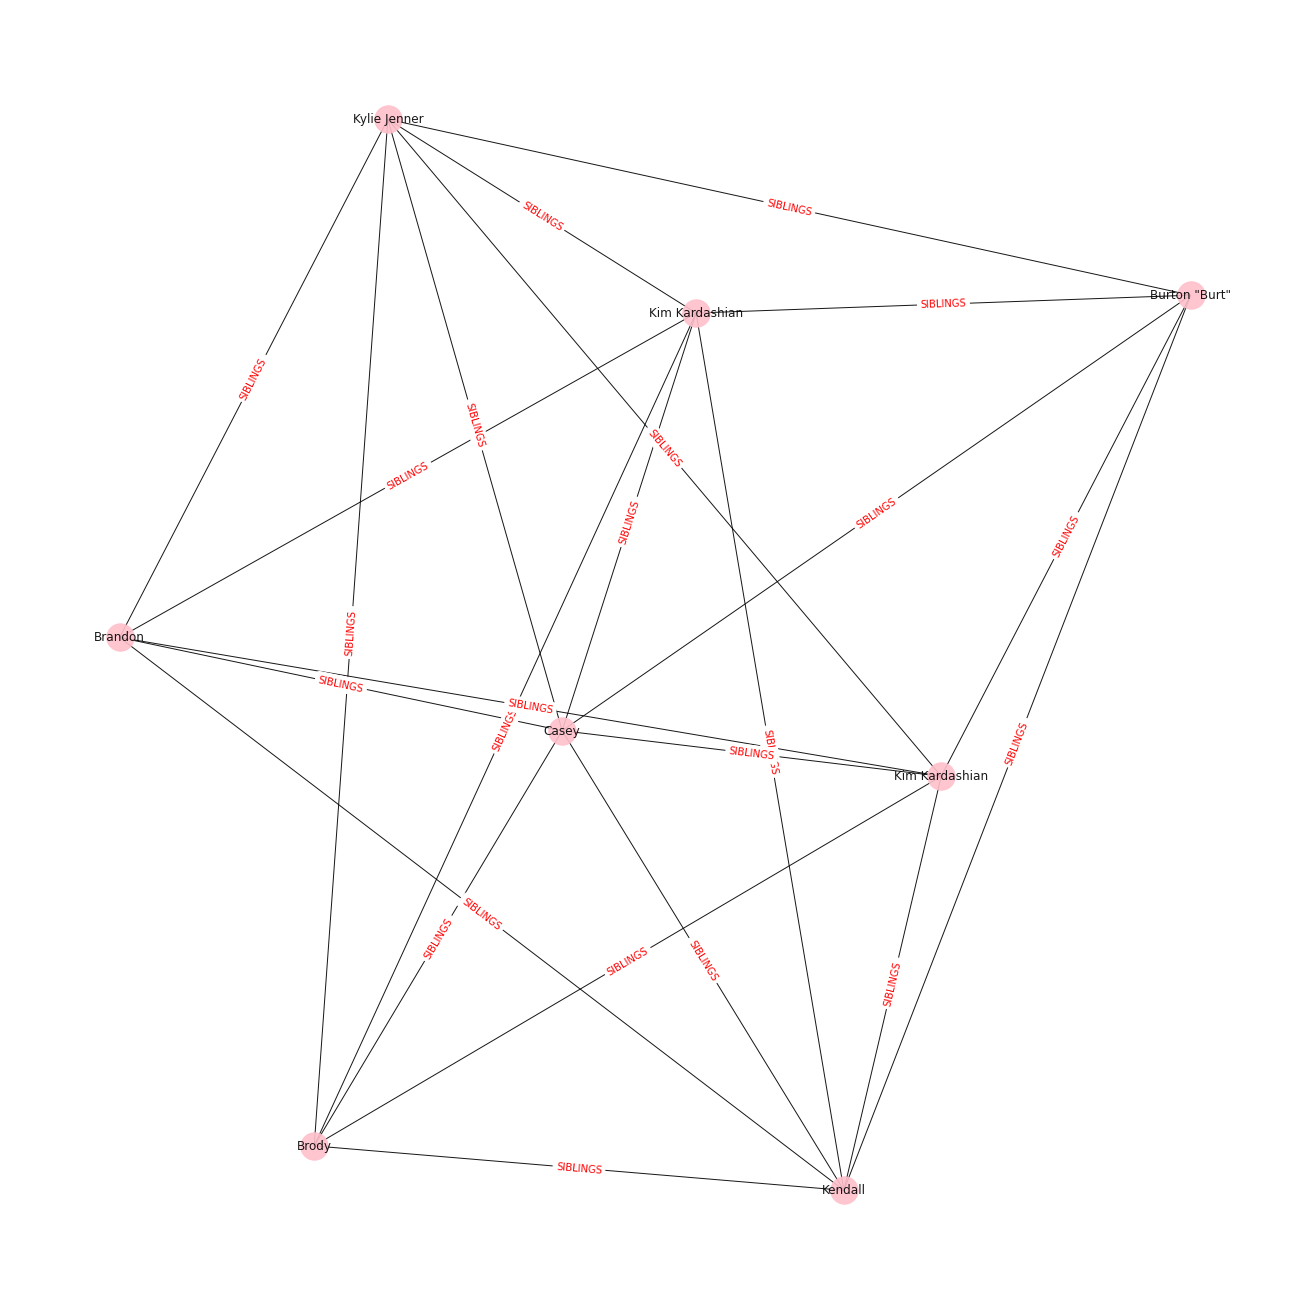

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(18,18))
pos = nx.spring_layout(G)
nx.draw(
    G, pos, edge_color='black', width=1, linewidths=1,
    node_size=750, node_color='pink', alpha=0.9,
    labels={node: node for node in G.nodes()}
)
nx.draw_networkx_edge_labels(
    G, pos,
    edge_labels=e_labels,
    font_color='red'
)